In [1]:
# This is a custom dataset that contains covid-19 x-ray images, viral pneumonia x-ray images, bacterial pneumonia x-ray iamges and normal person x-ray images.
# Each class contains 133 images.
# Dataset Source:
# https://github.com/ieee8023/covid-chestxray-dataset 
# https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia


import os
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [2]:
# You will need to mount your drive using the following commands:
# For more information regarding mounting, please check this out: https://stackoverflow.com/questions/46986398/import-data-into-google-colaboratory

#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
# Specify training data directory

xrayd = ('[...]/Chest_XRay')

In [4]:
# List the folders in the directory
os.listdir(xrayd)

['0', '1', '2', '3']

In [5]:
# Use image generator to generate tensor images data and normalize them
# Use 20% of the data for cross-validation  
#we want our model to GENERALIZE and not MEMORIZE

image_generator = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)


In [6]:
# Generate batches of 40 images
# Total number of images is 133*4 = 532 images
# Training is 428 (80%) and validation is 104 (20%)
# Perform shuffling and image resizing

train_generator = image_generator.flow_from_directory(batch_size = 40, directory = xrayd, shuffle = True, 
                                                      target_size = (256, 256), class_mode = 'categorical',
                                                     subset = 'training')


Found 428 images belonging to 4 classes.


In [7]:
validation_generator = image_generator.flow_from_directory(batch_size = 40, directory = xrayd, shuffle = True, 
                                                      target_size = (256, 256), class_mode = 'categorical',
                                                     subset = 'validation')

Found 104 images belonging to 4 classes.


In [8]:
# Generate a batch of 40 images and labels

train_images, train_labels = next(train_generator)

In [9]:
train_images.shape  #last output (3 here) is due to images being colored. So 3 = r,g,b

(40, 256, 256, 3)

In [10]:
train_labels.shape

(40, 4)

In [11]:
train_labels

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]],

In [12]:
# labels Translator (i.e dictionary of classification)

label_names = {0: 'Covid-19', 1: 'Normal', 2: 'Viral Pneumonia', 3: ' Bacterial Pneumonia'}



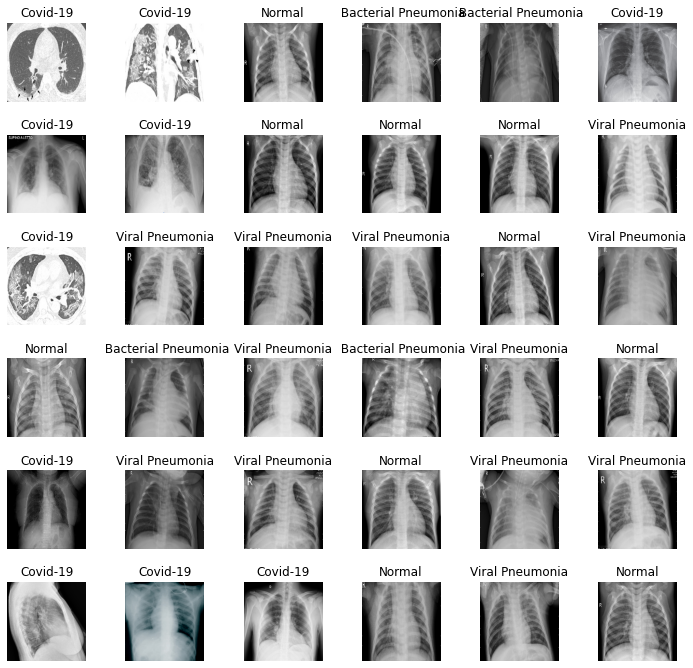

In [13]:
L = 6
W = 6

fig, axes = plt.subplots(L, W, figsize = (12,12))
axes = axes.ravel()  #flattens the axes 

#go over each image in trained data set and label them 

for i in np.arange(0, L*W):
    axes[i].imshow(train_images[i])
    axes[i].set_title(label_names[np.argmax(train_labels[i])])
    axes[i].axis('off')  #won't show nb of pixels.. preferenace for cleanliness
    
plt.subplots_adjust(wspace = 0.5)   #adjust spacing for better visualization

In [14]:
#transfer learning! 

basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor=Input(shape = (256, 256, 3)))

In [15]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [16]:
# freezing layers in the model
#done to add our trainable data and introduce new weights

for layer in basemodel.layers[:-10]:
    layers.trainable = False 


In [23]:
#build and train deep learning model! 

headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size= (4,4))(headmodel)
headmodel = Flatten (name = 'flatten')(headmodel)
#add dense fully connected neural network and activate with relu
headmodel = Dense(256, activation = 'relu')(headmodel)
headmodel = Dropout(0.3)(headmodel) #ensure network generalization // avoids overfitting by halting some codependancies!
#some steps come by trial and error, it's normal like trackpy detecting cell motiilty
headmodel = Dense(256, activation = 'relu')(headmodel)
headmodel = Dropout(0.3)(headmodel) 
headmodel = Dense(4, activation = 'softmax')(headmodel) #output // want to be saturated

In [24]:
#combine basemodel with classification headmodel 

model = Model(inputs = basemodel.input, outputs = headmodel)

In [25]:
model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.RMSprop(lr = 1e-4),
             metrics = ['accuracy'])

In [26]:
# using early stopping to exit training if validation loss is not decreasing after certain number of epochs (patience)
#patience = wait this much epochs before doing early stopping

earlystopping = EarlyStopping(monitor = 'val_loss', mode= 'min', patience = 20)

# save the best model with lowest validation loss
 
checkpointer = ModelCheckpoint(filepath = 'weights.hdf5', verbose = 1, save_best_only = True)  #verbose = how much info is plotted in training


In [27]:
#generate images and fit model to images

train_generator = image_generator.flow_from_directory(batch_size=4, directory = xrayd, shuffle = True, 
                                                     target_size = (256,256), class_mode = 'categorical',
                                                     subset = 'training')

validation_generator = image_generator.flow_from_directory(batch_size=4, directory = xrayd, shuffle = True, 
                                                     target_size = (256,256), class_mode = 'categorical',
                                                     subset = 'validation')

Found 428 images belonging to 4 classes.
Found 104 images belonging to 4 classes.


In [28]:
history = model.fit_generator(train_generator, epochs = 25, validation_data = validation_generator, 
                              callbacks = [checkpointer, earlystopping])

Epoch 1/25
107/107 [==============================] - ETA: 0s - loss: 0.3829 - accuracy: 0.8715
Epoch 00001: val_loss improved from inf to 8.21859, saving model to weights.hdf5
107/107 [==============================] - 315s 3s/step - loss: 0.3829 - accuracy: 0.8715 - val_loss: 8.2186 - val_accuracy: 0.2500
Epoch 2/25
107/107 [==============================] - ETA: 0s - loss: 0.0999 - accuracy: 0.9696
Epoch 00002: val_loss improved from 8.21859 to 4.10208, saving model to weights.hdf5
107/107 [==============================] - 315s 3s/step - loss: 0.0999 - accuracy: 0.9696 - val_loss: 4.1021 - val_accuracy: 0.2692
Epoch 3/25
107/107 [==============================] - ETA: 0s - loss: 0.0635 - accuracy: 0.9836
Epoch 00003: val_loss did not improve from 4.10208
107/107 [==============================] - 311s 3s/step - loss: 0.0635 - accuracy: 0.9836 - val_loss: 7.4599 - val_accuracy: 0.3173
Epoch 4/25
107/107 [==============================] - ETA: 0s - loss: 0.1557 - accuracy: 0.9650
Epo

In [30]:
#EVALUATE TRAINED DEEP LEARNING MODEL

history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Text(0, 0.5, 'Training Accuracy and Loss')

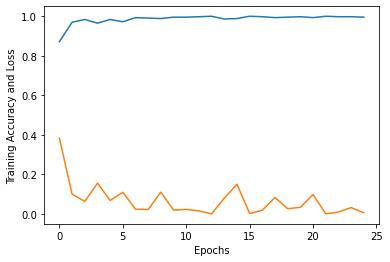

In [35]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy and Loss')

Text(0, 0.5, 'Validation Loss')

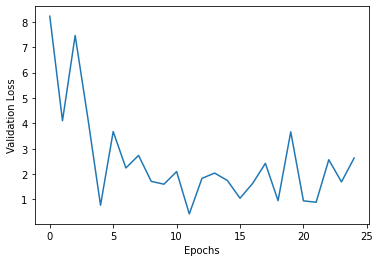

In [37]:
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')

Text(0, 0.5, 'Validation Accuracy')

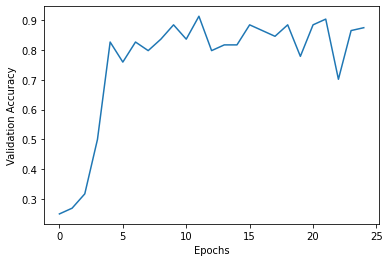

In [38]:
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')

In [39]:
#TEST DATA-------> MODEL HAS NOT SEEN THEM YET
#Perfect test to validate the model! Will it correctly identify the classification?? 

test_directory = ('C:/Users/HP/Desktop/DS Projects/20210509 OperationsDepartment/1. Original Data/4. Operations Department/Test')

In [40]:
test_gen = ImageDataGenerator(rescale = 1./255)
test_generator = test_gen.flow_from_directory(batch_size = 40, directory = test_directory, shuffle = True, 
                                             target_size = (256,256), class_mode = 'categorical')
                                        

Found 40 images belonging to 4 classes.


In [43]:
evaluate = model.evaluate_generator(test_generator, steps = test_generator.n//4, verbose =1)
print('Accuracy Test: {}'.format(evaluate[1]))

 1/10 [==>...........................] - 0s 13ms/step - loss: 2.8816 - accuracy: 0.8500
Accuracy Test: 0.8500000238418579


In [ ]:
#Amazing..... 85% accuracy on data it has never seen before

In [47]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

prediction = []
original = []
image = []


for i in range(len(os.listdir(test_directory))):
    for item in os.listdir(os.path.join(test_directory, str(i))):
        img = cv2.imread(os.path.join(test_directory, str(i), item))
        img = cv2.resize(img, (256,256))
        image.append(img)
        img = img / 255
        img = img.reshape(-1,256,256,3)
        predict = model.predict(img)
        predict = np.argmax(predict)
        prediction.append(predict)
        original.append(i)

In [49]:
score = accuracy_score(original, prediction)
print('Test Accuracy: {}'.format(score))

Test Accuracy: 0.85


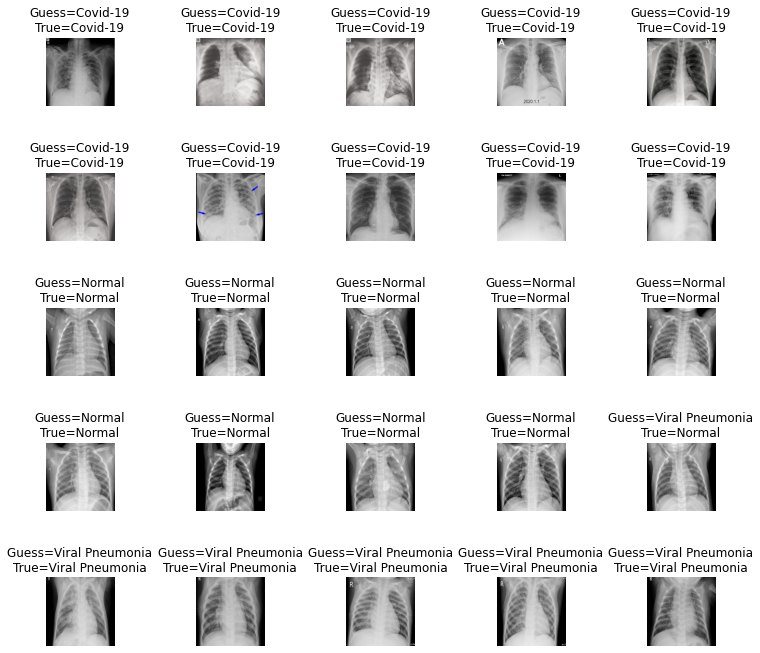

In [51]:
L=5
W=5

fig, axes = plt.subplots(L,W, figsize = (12,12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(image[i])
    axes[i].set_title('Guess={}\nTrue={}'.format(str(label_names[prediction[i]]),
                      str(label_names[original[i]])))
    axes[i].axis('off')
    plt.subplots_adjust(wspace = 1.2)

In [52]:
print(classification_report(np.asarray(original), np.asarray(prediction)))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           1       0.69      0.90      0.78        10
           2       0.88      0.70      0.78        10
           3       1.00      0.80      0.89        10

    accuracy                           0.85        40
   macro avg       0.87      0.85      0.85        40
weighted avg       0.87      0.85      0.85        40



Text(0.5, 1.0, 'Confusion_matrix')

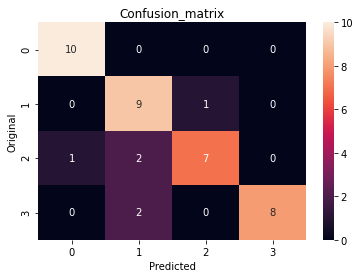

In [55]:
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Original')
ax.set_title('Confusion_matrix')